In [1]:
from matplotlib import pyplot as plt
from matplotlib import image as img
import netCDF4 as nc
import numpy as np
import math
from scipy import signal, interpolate

In [2]:
#im = img.imread('../rippleTests/5645Degrees.png')
im = img.imread('56Vertical.png')
np.shape(im)

(1001, 1001, 3)

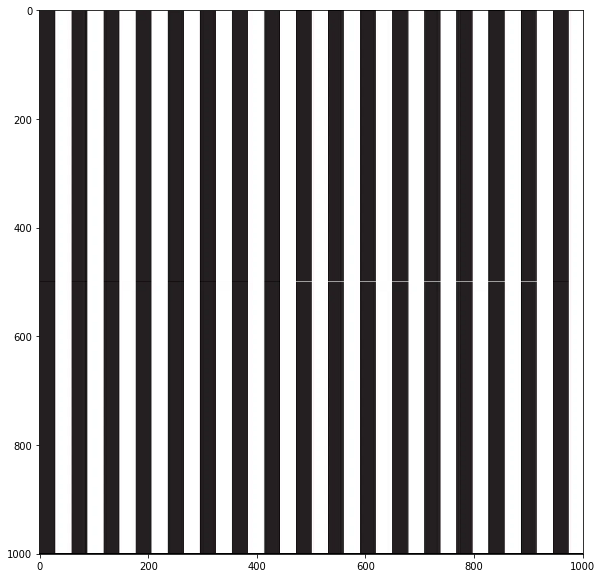

In [3]:
plt.figure(figsize=[10, 10])
plt.imshow(im)
plt.show()

In [4]:
#Estimated dimensions of one pixel
dx = 0.01
dy = 0.01

#Create x and y dimensions, as well as edgelength of a subimage
# the x and y should allow the center to be at 0 and allow for -x, +x and -y and +y
# take it to -5 m to 5 m in both x, y 
x = np.arange(-500*dx, 500*dx, dx)
y = np.arange(-500*dy, 500*dy, dy)

print(np.shape(x))
#squareEdgeLength = 2048*dx
m=256
n=m

(1000,)


In [5]:
 def subImageInterp(x, y, z, m, n):
    #This function creates and interpolates over the subimage region
    #Input:
    #     x: coordinates in the x direction
    #     y: coordinates in the y direction
    #     z: z = f(x, y) i.e. sonar return strength, pixel strength
    #     m: number of points in the x direction, ideally a power of 2
    #     n: number of points in the y direction, ideally a power of 2
    #Output:
    #     xInterp: x-coordinates of the interpolated grid
    #     yInterp: y-coordinates of the interpolated grid
    #     zInterp: Interpolated z values
    
    #Define the center
    xCenter = 0 
    #yCenter = -5-squareEdgeLength/2.
    yCenter = 0 

    
    #FFT is performed on a collection of subimages
    squareEdgeLength = max(m*dx, n*dy)
    
    print(squareEdgeLength)
    
    #Define the 4 corners
    xSquareRange = [xCenter - squareEdgeLength/2., xCenter + squareEdgeLength/2.]
    ySquareRange = [yCenter - squareEdgeLength/2., yCenter + squareEdgeLength/2.]
    
#    print(xSquareRange)
#    print(ySquareRange)
    
    #Get the datapoints that exist within the subimage
    xMask = np.logical_and(x > xSquareRange[0], x < xSquareRange[1])
    yMask = np.logical_and(y > ySquareRange[0], y < ySquareRange[1])
#    print(x)
#    print(xSquareRange)
#    print(ySquareRange)
    
#    print(np.shape(xMask))
#    print(np.shape(x))
    
    xReal = x[xMask]
#    print(x[xMask])
    yReal = y[yMask]
    zReal = z[np.ix_(xMask, yMask)]
        
    #Create the region to interpolate over
    xInterp = np.arange(xSquareRange[0], xSquareRange[1], dx)
    yInterp = np.arange(ySquareRange[0], ySquareRange[1], dy)
    
    #Standardize the size of the regions
    xInterp = xInterp[0:m]
    yInterp = yInterp[0:n]

    #Make the x and y arrays 2-dimensional
    xInterpGrid, yInterpGrid = np.meshgrid(xInterp, yInterp)

    #Reshape the data for the interpolation method
    mTemp = np.size(xReal)
    nTemp = np.size(yReal)
        
    xReal, yReal = np.meshgrid(xReal, yReal)
        
#    print(mTemp)
#    print(nTemp)
    
#    print(np.shape(xReal))
#    print(xReal)
    
    xReal = xReal.reshape(mTemp*nTemp)
    yReal = yReal.reshape(mTemp*nTemp)
    zReal = zReal.reshape(mTemp*nTemp)
        
    #Perform a scattered interpolant
    zInterp = interpolate.griddata((xReal, yReal), zReal,
                                    (xInterpGrid, yInterpGrid), method='cubic')
        
    #Remove NaNs
    zInterp[np.isnan(zInterp)] = 0
    
#    plt.figure(figsize=[10, 10])
#    plt.pcolor(xInterp, yInterp, zInterp)
#    plt.show()
    
#    print(np.shape(xInterp))
#    print(np.shape(zInterp))
    
    return xInterp, yInterp, zInterp
    
def spectrum(x, y, z, dx, dy, m, n):
    #Return a power and associated wavenumbers in the x and y direction
    #Input:
    #     x: coordinates in the x direction
    #     y: coordinates in the y direction
    #     z: z = f(x, y) i.e. sonar return strength, pixel strength
    #     dx: step size in the x direction
    #     dy: step size in the y direction
    #     m: number of points in the x direction, ideally a power of 2
    #     n: number of points in the y direction, ideally a power of 2
    #Output:
    #     pZ: power estimate of the fft, pZ = F(kx, ky)
    #     kx: wavenumber in the x direction
    #     ky: wavenumber in the y direction
    
    #First step is to remove a 2nd degree polynomial
    yTrend = np.polyfit(y, z, 2)
    
    xGrid, yGrid = np.meshgrid(x, y)
    
    z = z - np.polyval(yTrend, yGrid)
    
    z = z.transpose()
    
    xTrend = np.polyfit(x, z, 2)
        
    z = z - np.polyval(xTrend, xGrid.transpose())
    
    z = z.transpose()
    
    #Perform the fft
    fftZ = np.fft.fft2(z)
    
    #Estimate power
    pZ = abs(fftZ)**2
    
    pZ[[1, 2, -1], [1, 2 , -1]] = 0
    
    if m%2 == 0:
        pZ[int(m/2+1), :] = 0
    if n%2 == 0:
        pZ[:, int(n/2+1)] = 0
    
    pZ = np.fft.fftshift(pZ)
    
    #Estimate wavenumbers
    xRange = list(range(0, m))
    kx = [((1/2+val/m)%1)-1/2 for val in xRange]
    kx = [val * 2 * math.pi / dx for val in kx]
    kx = np.fft.fftshift(kx)

    yRange = list(range(0, n))
    ky = [((1/2+val/n)%1)-1/2 for val in yRange]
    ky = [val * 2 * math.pi / dy for val in ky]
    ky = np.fft.fftshift(ky)
    
    return pZ, kx, ky
    

def findRipple(x, y, z, m, n):
    #Take ripple image data and return a ripple orientation and wavelength
    #Input:
    #     x: coordinates in the x direction
    #     y: coordinates in the y direction
    #     z: z = f(x, y) i.e. sonar return strength, pixel strength
    #     m, n: number of points for FFT also determine the size of the squarebox
    #     hgt: height of the sonar
    #Output:
    #     theta: ripple orientation
    #     wavelength: ripple wavelength
    
    
    #Define parameters
    
    #rot = 0
    #north = 90 
    imgRange = 1
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    print('dx:',dx)
    maxRange = imgRange
    
    sizeX, sizeY = np.shape(z)
    
    imgCenterX = x[int(sizeX/2)]
    imgCenterY = y[int(sizeY/2)]
    
    #print(imgCenterX)
    #print(imgCenterY)
    
    #Number of points for FFT
    
#    m = 2048
#    n = 2048

    #Create a Filter
    F=np.array([[0, 1, 0], [1, 2, 1], [0, 1, 0]])
    F=F/F.sum()
    
    #Create the subimage
    xInterp, yInterp, zInterp = subImageInterp(x, y, z, m, n)
    #Perform the fft
    pZ, kx, ky = spectrum(xInterp, yInterp, zInterp, dx, dy, m, n)
    
    #Remove low falues
    xMask = abs(kx) <= 3.3
    yMask = abs(ky) <= 3.3
    
    pZ[np.ix_(xMask, yMask)] = 0
    
    #Apply the filter # EDGE DETECTION 
    pZ = signal.convolve2d(pZ, F, 'same')
    
    #Get max wavenumber values
    kx, ky = np.meshgrid(kx, ky)
    
    KX = kx[pZ == pZ.max()]
    KY = ky[pZ == pZ.max()]
    
    #If there are multiple points, use the first one
    if type(KX) == np.ndarray:
        KX = KX[0]
        KY = KY[0]
    
    #Calculate the orientation
#    theta=math.atan2(KY/KX)*180/math.pi
    theta=math.atan2(KY, KX)*180/math.pi
#    theta=math.atan(KY/KX)*180/math.pi
#    theta=-(theta-90)
#    theta=theta+90
#    if theta < 0:
#        theta += 360
#    if theta >= 180:
#        theta -= 180
    
    #Caulculate the wavelength
    wavelength = 2*math.pi/math.sqrt(KX**2 + KY**2)
    
    return theta, wavelength, xInterp, yInterp, zInterp


In [6]:
#img1 = np.flip(img.imread(imList[imRange[0]]), 0)
# TSK flip the image and convert to gray scale

img1 = np.dot(im[:,:,:3],[0.2989, 0.5870, 0.1170])
#print(img1)
#print(np.shape(img1))
#print(np.shape(x))
#Get the orientation and dimensions

theta, wavelength, xInterp, yInterp, zInterp = findRipple(x, y, img1, m, n)
print('theta:',theta)
print('wavelength:',wavelength)

dx: 0.009999999999999787
2.56
theta: -153.43494882292202
wavelength: 0.5724334022399339


(1000,)
(1000,)
(1001, 1001)


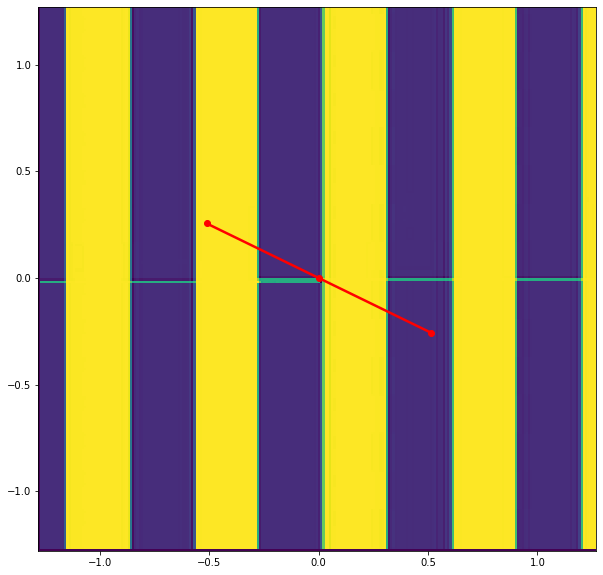

In [7]:
print(np.shape(x))
print(np.shape(y))
print(np.shape(img1))

plt.figure(figsize=[10, 10])
#plt.pcolor(x, y, img1)
plt.pcolor(xInterp, yInterp, zInterp)

xPlot = [-wavelength*math.cos(math.radians(-(theta))), 0,
                    wavelength*math.cos(math.radians(-(theta)))]

yPlot = [-wavelength*math.sin(math.radians(-(theta))), 0,
                    wavelength*math.sin(math.radians(-(theta)))]

plt.plot(xPlot, yPlot, 'ro-', linewidth=2.5)

plt.show()
